In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import copy
import scipy as sc

In [3]:
from scripts.QC.GT_matrices import Genotypes, Pedigree

 ### Load imputed Genotypes

In [5]:
home = "/Users/tilro532/dip_home/nas/stripes_AIL_gg6a/stripes_2_rqtl"
initial_file = os.path.join(home, "F15","F15_gt_matrix_FilteredForBinsize1000000.csv" )
gt = Genotypes(gt_file=initial_file, pedigree_file="/Users/tilro532/dip_home/nas/pedigree/AIL_pedigree_20190826.tsv")
gt.construct_density_bin_matrix(folder="/Users/tilro532/dip_home/nas/stripes_AIL_gg6a/")
gt.get_congruency_matrix()
gt.order_matrices()

In [6]:
len(gt.gt_matrix.columns)

584

In [7]:
!head -1 {initial_file} | wc 

       1       1    4185


 ### load GoldenGate markers

In [8]:
markers = pd.read_csv("./r_liftover/full_f15_markers_geno.csv", ).transpose()
markers.columns = markers.iloc[0].astype(int).astype(str)
markers = markers[1:]

In [9]:
positions = pd.read_csv("./r_liftover/new_positions_for_F15markers.csv")

In [10]:
markers = markers.replace(2, "A")
markers = markers.replace(1, "B")
markers = markers.replace(0, "C")


markers = markers.replace("A", 1)
markers = markers.replace("B", 0)
markers = markers.replace("C", -1)


In [11]:
positions = copy.deepcopy(positions[["seqnames", "start", "X"]])


In [12]:
positions.columns = ['chr', 'pos', 'marker']

In [13]:
positions.index = positions["marker"]
del(positions["marker"])

In [14]:
a = positions.merge(markers, how="inner", right_index=True, left_index=True)

### subset GGmarkers and stripesmarkers for Chromosome 1

In [15]:
a1 = a.loc[a["chr"]=="chr1"]

In [16]:
gt1 = gt.gt_matrix[[i for i in gt.gt_matrix.columns if i.startswith("1-")]]

### find intersection of Samples

In [17]:
all_samples_present_in_both = set.intersection(set(gt1.index),set(a1.columns))

In [18]:
len(all_samples_present_in_both)

780

 ### bin markers according to position in MB

In [19]:
j = 0
d = {i:[]for i in range(198)}
for i,k in a1.iterrows():
    
    if (k["pos"]/1000000) > j:
        #print("position", k["pos"]/1000000)
        #print("position", k["pos"]//1000000)
        j = k["pos"]//1000000
        #print("is in", j)
        d[j].append(k[3:])
    

In [20]:
dd = {}
for key, item in d.items():
    #print(key)
    currbin= pd.DataFrame(item)
    if len(item) == 0:
        #print("len is 0, making empty array")
        mean = np.empty(824)
        mean.fill(np.nan)
    else:
        mean = currbin.mean(axis=0, skipna=True)
    dd[key] = mean    

In [21]:
binned_gt = pd.DataFrame.from_dict(dd)

In [22]:
#binned_gt

In [23]:
binned_gt.columns = ["1-"+str(i+1) for i in range(198)]

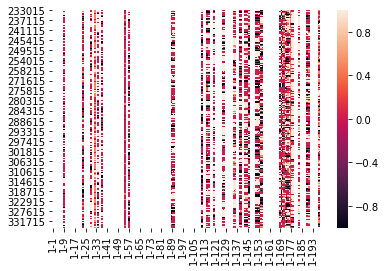

In [24]:
sns.heatmap(binned_gt)
plt.show()

In [25]:
binned_gt_marker_subset = binned_gt.transpose().dropna(how="all").transpose()

In [26]:
binned_gt_marker_subset["id"] =  binned_gt_marker_subset.index

In [27]:
binned_gt_marker_subset_lf = binned_gt_marker_subset.unstack().reset_index()

In [28]:
binned_gt_marker_subset_lf.columns = ["chr", "ID", "value"]

In [29]:
#a1_subset = a1.transpose().loc[list(all_samples_present_in_both)]

In [30]:
gt1_f = gt1.unstack().reset_index()

In [31]:
#gt1_f

In [32]:
gt1_f.columns = ["chr", "ID", "value"]

In [37]:
#gt1_f

In [70]:
merged = pd.merge(binned_gt_marker_subset_lf, gt1_f, how='inner', on=["chr", "ID"], left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_GG', '_stripes'), copy=True, indicator=False,
         validate=None)

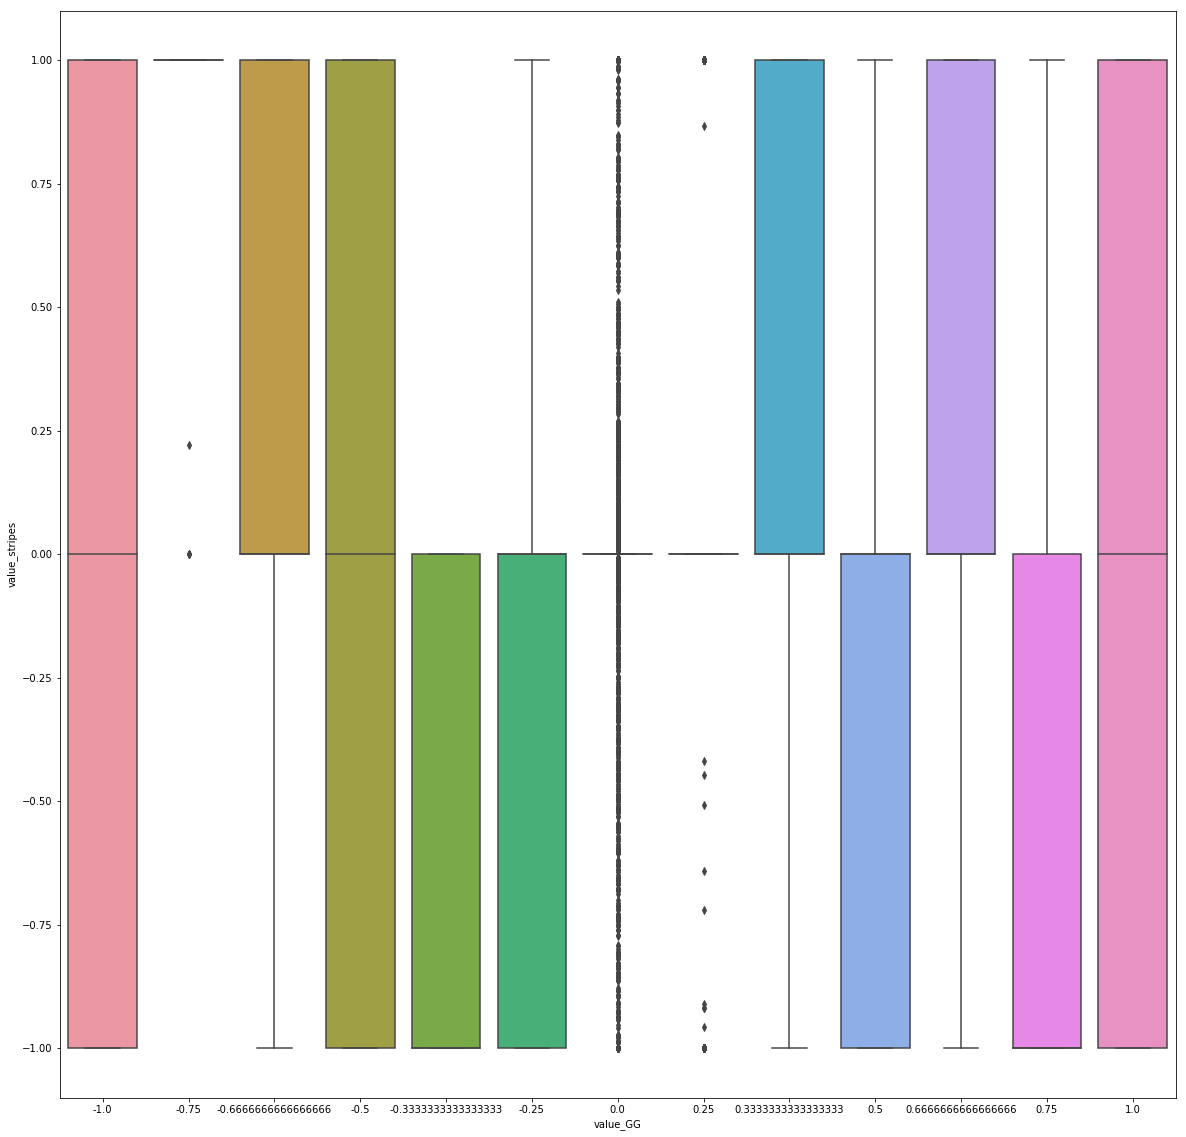

In [73]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,20))
sns.boxplot(mnona["value_GG"], mnona["value_stripes"], ax=ax)
plt.show()


In [72]:
mnona = merged.dropna()

/Users/tilro532/miniconda3/envs/v3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


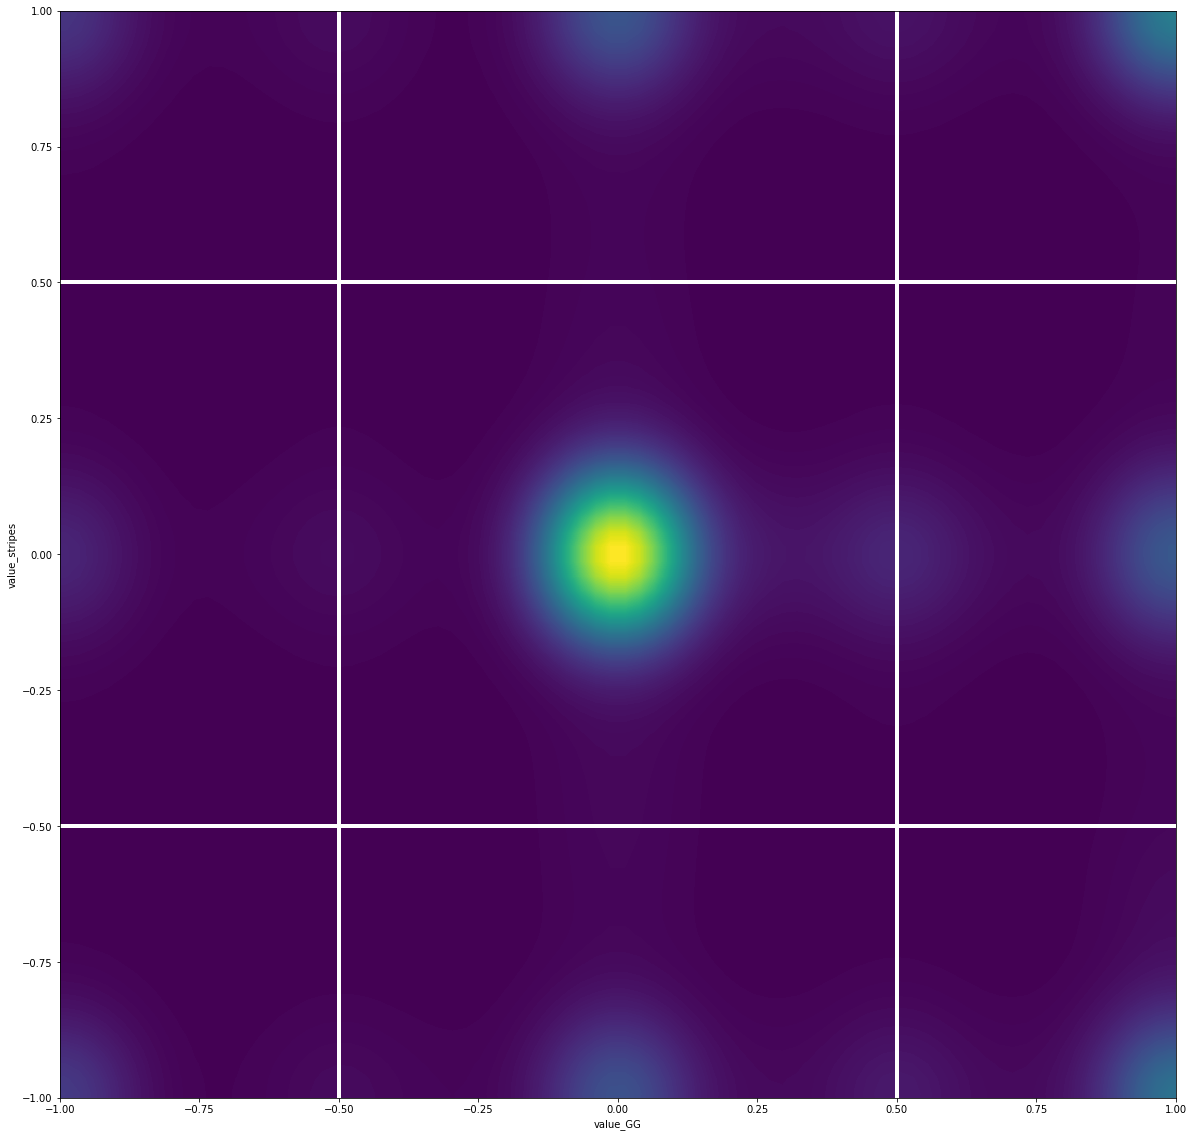

In [74]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,20))
sns.kdeplot(mnona["value_GG"], mnona["value_stripes"], ax=ax,shade=True, cmap="viridis", n_levels=200)
ax.axhline(-0.5, color="White", lw=4)
ax.axhline(0.5, color="White", lw=4)
ax.axvline(0.5, color="White", lw=4)
ax.axvline(-0.5, color="White", lw=4)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

plt.show()


In [75]:
cn = []
for i, k in merged.iterrows():
    if k["value_GG"]== k["value_stripes"]:
        cn.append(1)
    else:
        cn.append(0)
    

In [76]:
merged["same"] = cn

In [77]:
samples = merged.groupby("ID")
marker = merged.groupby("chr")

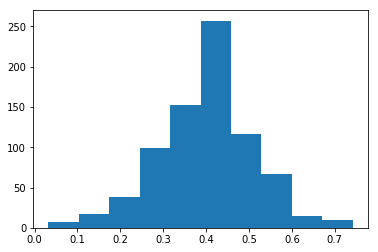

In [78]:
plt.hist(samples.mean()["same"])
plt.show()

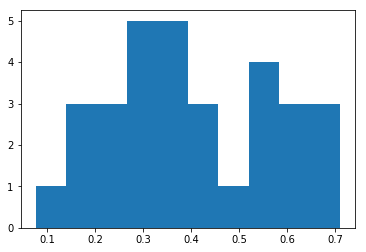

In [79]:
plt.hist(marker.mean()["same"])
plt.show()

In [80]:
#for i, k, in d.items():
#    if len(k)>0:
#        print(len(k[0]))

In [81]:
len(binned_gt)

824

In [82]:
len(all_samples_present_in_both)

780

In [83]:
set_int = (set.intersection(set(binned_gt.index), set(all_samples_present_in_both)))

In [84]:
binned_gt_samples = binned_gt.loc[set_int].transpose().dropna(how="all").transpose()

In [85]:
gt1_samples = gt1.loc[set_int]

In [86]:
called_bins = set.intersection(set(binned_gt_samples.columns),set(gt1_samples.columns))

In [87]:
gt1_samples_bins = gt1_samples[called_bins]

TypeError: unhashable type: 'set'

In [ ]:
binned_gt_samples_bins = binned_gt_samples[called_bins]

In [ ]:
def _order_bins(matrix):
    """
    take the columns ( i.e. bins) and order them logically.
    e.g. [1-1, 1-2, 1-3] instead of [1-1, 1-10, 1-11]
    """
    b=matrix
    bin_dict = {}
    for i in b:
        i = i.split("-")
        bin_dict.setdefault(int(i[0]),[]).append(int(i[1]))

    bin_list_ordered = []
    kl = list(bin_dict.keys())
    kl.sort()
    for key in kl:
        bin_dict[key].sort()
        for j in bin_dict[key]:
            bin_name = str(key)+"-"+str(j)
            bin_list_ordered.append(bin_name)
    return bin_list_ordered

In [88]:
ordered_cols = _order_bins(gt1_samples_bins)

NameError: name '_order_bins' is not defined

NameError: name 'gt1_samples_bins' is not defined

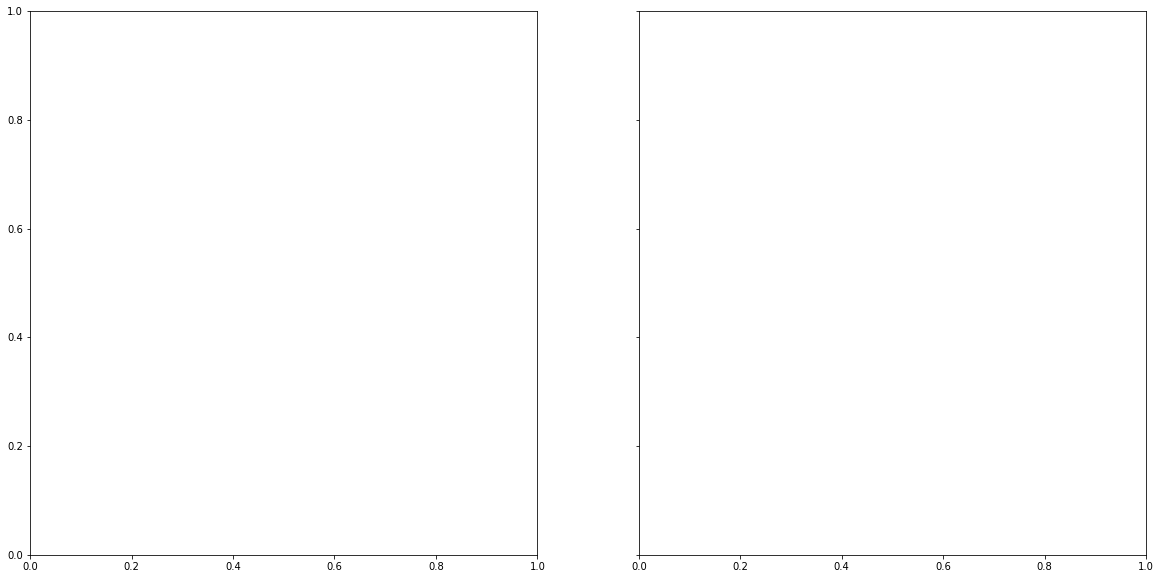

In [89]:
fig, (ax,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,10), sharex=True, sharey=True)
sns.heatmap(gt1_samples_bins[ordered_cols], ax=ax)
sns.heatmap(binned_gt_samples_bins[ordered_cols], ax=ax2)
plt.tight_layout()
plt.show()

In [ ]:
cluster_by_imputed = sc.cluster.hierarchy.linkage(gt1_samples_bins[ordered_cols].dropna(),
                                           method="ward",
                                           metric='euclidean',
                                           optimal_ordering=True)

In [ ]:
cluster_by_GG = sc.cluster.hierarchy.linkage(binned_gt_samples_bins[ordered_cols].dropna().loc[gt1_samples_bins[ordered_cols].dropna().index],
                                           method="ward",
                                           metric='euclidean',
                                           optimal_ordering=True)


In [ ]:
hm = sns.clustermap(gt1_samples_bins[ordered_cols].dropna(), col_cluster=False, row_linkage=cluster_by_imputed, cmap="viridis", figsize=(20,20))
ax = hm.ax_heatmap
ax.axvline(11, color="white", lw=2)
ax.axvline(16, color="white", lw=2)
#ax.axvline(18, color="white", lw=2)
ax.axvline(27, color="red", lw=2)
ax.axvline(25, color="red", lw=2)
ax.set_title("imputed Genotypes", size=20)
plt.show()

In [ ]:
hm = sns.clustermap(binned_gt_samples_bins[ordered_cols].dropna().loc[gt1_samples_bins[ordered_cols].dropna().index], col_cluster=False,row_linkage=cluster_by_imputed,cmap="viridis", figsize=(20,20))
ax = hm.ax_heatmap
ax.axvline(11, color="white", lw=2)
ax.axvline(16, color="white", lw=2)
#ax.axvline(18, color="white", lw=2)
ax.axvline(27, color="red", lw=2)
ax.axvline(25, color="red", lw=2)
ax.set_title("Golden Gate Genotypes", size=20)

plt.show()

In [ ]:
from scipy.stats.stats import pearsonr  
def get_r2_numpy_corrcoef(x, y):
    return np.corrcoef(x, y)[0, 1]**2

In [ ]:
GG = binned_gt_samples_bins[ordered_cols].dropna().loc[gt1_samples_bins[ordered_cols].dropna().index]
ST = gt1_samples_bins[ordered_cols].dropna()

GGT = GG.transpose()
STT = ST.transpose()

In [90]:
pr = {}
for i , k in GGT.iterrows():
    #if len(Counter(k).values()) <= 3:
    #print(STT.loc[i])
    #print(pearsonr(k, STT.loc[i]))
    pr[i]=pearsonr(k, STT.loc[i])[0]
    #print(pearsonr(STT.loc[i], k))
    #print(get_r2_numpy_corrcoef(k, STT.loc[i]))

NameError: name 'GGT' is not defined

In [ ]:
direction = {}
for key, item in pr.items():
    if item<0:
        direction[key] = -1
    else:
        direction[key] = 1

In [ ]:
for i , k in GGT.iterrows():
    k = k*direction[i]

In [ ]:
hm = sns.clustermap(GGT.transpose(), col_cluster=False,cmap="viridis", row_linkage=cluster_by_imputed, figsize=(20,20))
ax = hm.ax_heatmap
ax.axvline(11, color="white", lw=2)
ax.axvline(16, color="white", lw=2)
#ax.axvline(18, color="white", lw=2)
ax.axvline(27, color="red", lw=2)
ax.axvline(25, color="red", lw=2)
ax.set_title("Golden Gate Genotypes", size=20)

plt.show()

In [ ]:
pr[0.6221534063221746]

In [ ]:
GGT.loc["1-139"]

In [ ]:
STT.loc["1-139"]

In [ ]:
plt.scatter(STT.loc["1-139"], GGT.loc["1-139"], alpha=0.1)
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(30,10))
ax.plot(GGT.loc["1-139"], color="Red")
ax.plot(STT.loc["1-139"], color="Blue")
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(range(len(pr)),pr)
ax.axhline(0.4, color="red")
ax.axhline(-0.4, color="red")


In [ ]:
plt.hist(pr.keys())

In [ ]:
GGT.transpose()

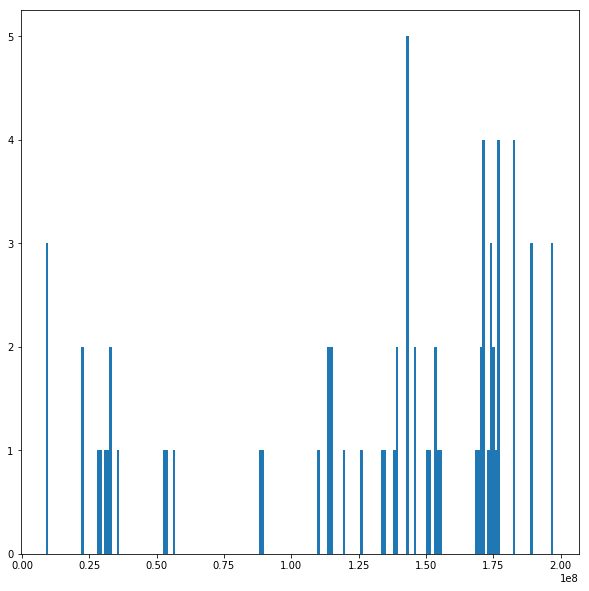

In [47]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
ax.hist(a1.pos, bins=200)
#ax.set_xlim(0.5*1e8, 0.6*1e8)
plt.show()

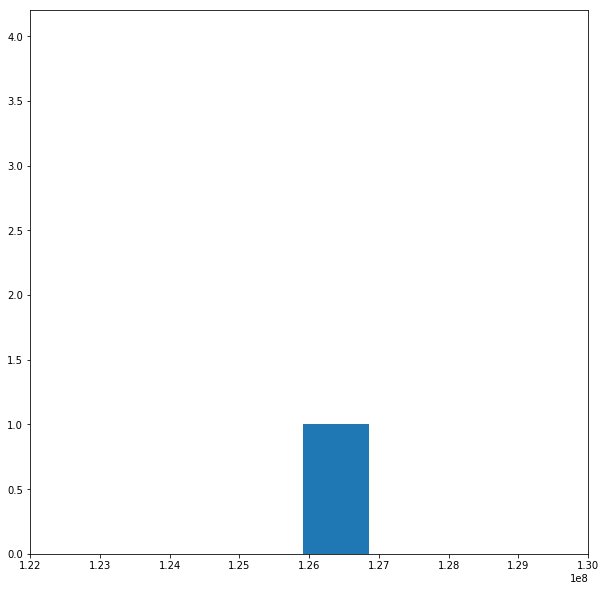

In [67]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
ax.hist(a1.pos, bins=198)
ax.set_xlim(1.22*1e8, 1.3*1e8)
plt.show()

In [69]:
list(a1.pos/1e6)

[8.883994,
 8.912936,
 8.959004,
 22.507858,
 22.867275,
 28.519753,
 28.742506,
 31.407322,
 31.5205,
 33.109344,
 33.267647,
 36.168263,
 53.135388,
 53.885881,
 56.23131,
 88.288637,
 89.793898,
 110.534187,
 114.118715,
 114.329382,
 114.899198,
 115.10253,
 119.465676,
 126.167075,
 134.143579,
 134.365873,
 138.289666,
 139.032578,
 139.80074,
 142.84801,
 142.97431,
 143.003837,
 143.317865,
 143.407863,
 145.579464,
 145.647342,
 150.929579,
 151.443877,
 153.645775,
 153.846618,
 154.088899,
 154.915579,
 168.271271,
 169.935296,
 170.029167,
 170.439956,
 171.185457,
 171.329418,
 171.549616,
 171.601631,
 172.867207,
 173.815317,
 174.118054,
 174.515225,
 174.860183,
 175.102555,
 176.059576,
 176.557071,
 176.839439,
 176.999778,
 177.369732,
 182.553715,
 182.715674,
 182.753191,
 182.857245,
 188.85904,
 189.119224,
 189.536264,
 197.269868,
 197.121948,
 196.781584]